# 1. Imports

In [611]:
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import interpolate
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast
from applefy.utils.positions import center_subpixel
from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma
from applefy.utils.file_handling import save_as_fits

from s4hci.detection_limits.applefy_wrapper import PCADataReductionGPU, S4DataReduction

from s4hci.utils.setups import contrast_grid_setup_1

# 2. Load the data

In [2]:
dataset_name = "HD22049_303_199_C-0065_C_"

In [3]:
dataset_file = Path("/fast/mbonse/s4/30_data/" + dataset_name + ".hdf5")
experiment_root_dir = Path("/fast/mbonse/s4/70_results/10_contrast_grids/" + dataset_name)

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

psf_template = np.median(raw_psf_template_data, axis=0)

dit_psf_template = 0.0042560
dit_science = 0.08
fwhm = 3.6
pixel_scale=0.02718

In [5]:
# we cut the image to 91 x 91 pixel to be slightly larger than 1.2 arcsec
cut_off = int((science_data.shape[1] - 91) / 2)
science_data = science_data[:, cut_off:-cut_off, cut_off:-cut_off]

# 3. Compute contrast grids

In [6]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    scaling_factor=1., # A factor to account e.g. for ND filters
    checkpoint_dir=experiment_root_dir)

In [7]:
# get fake planet setup
flux_ratios, separations, num_fake_planets = contrast_grid_setup_1(fwhm)

In [8]:
tmp_config_dir = deepcopy(contrast_instance.config_dir)
contrast_instance.config_dir = None
contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)
contrast_instance.config_dir = tmp_config_dir

## 3.1 Restore cADI results

## 3.2 Restore PCA results

In [9]:
pca_numbers = np.concatenate(
        [np.arange(0, 20, 2)[1:],
         np.arange(20, 50, 5),
         np.arange(50, 100, 10),
         np.arange(100, 200, 20),
         np.arange(200, 550, 50)])

pca_model = PCADataReductionGPU(
    approx_svd=8000,
    pca_numbers=pca_numbers,
    device=0,
    work_dir=None,
    special_name="pca_stacked_05",
    verbose=True)

In [10]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=pca_model,
    num_parallel=1)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:19<00:00, 49.53it/s]

[DONE]


## 3.3 Restore S4 results

In [11]:
s4_model = S4DataReduction(
    special_name="S4_rotation_loss",
    device="cpu",
    work_dir=None,
    verbose=True)

old_results = contrast_instance.results_dict
contrast_instance.run_fake_planet_experiments(
    algorithm_function=s4_model,
    num_parallel=1)
contrast_instance.results_dict.update(old_results)

Running fake planet experiments...

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 946/946 [00:01<00:00, 621.72it/s]

[DONE]


## 3.4 Compute the grid

In [12]:
# Use apertures pixel values
photometry_mode_planet = AperturePhotometryMode(
    "F",
    psf_fwhm_radius=fwhm/2,
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "P",
    psf_fwhm_radius=fwhm/2)

In [13]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [14]:
statistical_test = TTest()

In [15]:
contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=32,
    num_rot_iter=10,
    compute_snr_grid=True,
    safety_margin=2.5,
    pixel_scale=pixel_scale)

Computing contrast grid for s4_mean_S4_rotation_loss
Computing contrast grid with multiprocessing:
...................................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...............

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.............

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.......................................................................[DONE]
Computing contrast grid for s4_median_S4_rotation_loss
Computing contrast grid with multiprocessing:
...................................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


...........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise
/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.........

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


................

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


......

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: invalid value encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


..

/lustre/home/mbonse/2023_s4/50_code/applefy/applefy/statistics/parametric.py:110: RuntimeWarning: divide by zero encountered in scalar divide
  statistic_t = (y_bar_planet - x_bar_noise) / noise


.....................................................................[DONE]
Computing contrast grid for pca_stacked_05_PCA_002_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for pca_stacked_05_PCA_004_components
Computing contrast grid with multiprocessing:
...........................................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for pca_stacked_05_PCA_006_components
Co

# 4. Save the residuals

In [ ]:
# PCA
all_residuals = []

for tmp_method_name, tmp_result in contrast_instance.contrast_results.items():
    if tmp_method_name.startswith("s4_"):
        continue
    all_residuals.append(tmp_result.residuals)
    
all_residuals = np.array(all_residuals)
save_as_fits(all_residuals, experiment_root_dir / Path("merged_residuals_pca_HD22049_303_199_C-0065_C.fits"))

In [ ]:
# S4
s4_residuals_mean = contrast_instance.contrast_results["s4_mean_S4_rotation_loss"].residuals
s4_residuals_median = contrast_instance.contrast_results["s4_median_S4_rotation_loss"].residuals

save_as_fits(s4_residuals_mean, experiment_root_dir / 
             Path("merged_residuals_s4_mean_HD22049_303_199_C-0065_C.fits"))

save_as_fits(s4_residuals_median, experiment_root_dir / 
             Path("merged_residuals_s4_median_HD22049_303_199_C-0065_C.fits"))

# 5. Plot the contrast grids

In [68]:
baseline_grids = deepcopy(contrast_grids)

special_names = ["s4_mean_S4_rotation_loss", 
                 "s4_median_S4_rotation_loss",
                 'pca_stacked_05_PCA_035_components']
for special_name in special_names:
    del baseline_grids[special_name]
    
baseline_grids.keys()

dict_keys(['pca_stacked_05_PCA_002_components', 'pca_stacked_05_PCA_004_components', 'pca_stacked_05_PCA_006_components', 'pca_stacked_05_PCA_008_components', 'pca_stacked_05_PCA_010_components', 'pca_stacked_05_PCA_012_components', 'pca_stacked_05_PCA_014_components', 'pca_stacked_05_PCA_016_components', 'pca_stacked_05_PCA_018_components', 'pca_stacked_05_PCA_020_components', 'pca_stacked_05_PCA_025_components', 'pca_stacked_05_PCA_030_components', 'pca_stacked_05_PCA_040_components', 'pca_stacked_05_PCA_045_components', 'pca_stacked_05_PCA_050_components', 'pca_stacked_05_PCA_060_components', 'pca_stacked_05_PCA_070_components', 'pca_stacked_05_PCA_080_components', 'pca_stacked_05_PCA_090_components', 'pca_stacked_05_PCA_100_components', 'pca_stacked_05_PCA_120_components', 'pca_stacked_05_PCA_140_components', 'pca_stacked_05_PCA_160_components', 'pca_stacked_05_PCA_180_components', 'pca_stacked_05_PCA_200_components', 'pca_stacked_05_PCA_250_components', 'pca_stacked_05_PCA_300_com

In [69]:
all_grids = np.array([tmp_grid.values #.applymap(fpf_2_gaussian_sigma)
                      for tmp_grid in baseline_grids.values()])

In [70]:
over_all_best = deepcopy(contrast_grids["pca_stacked_05_PCA_002_components"])
over_all_best.iloc[:, :] = np.max(all_grids, axis=0)
over_all_best.index = flux_ratio2mag(over_all_best.index)

In [71]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"SNR [$T_{obs}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)
    xlabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_xticklabels()]
    _=heat.set_xticklabels(xlabels)

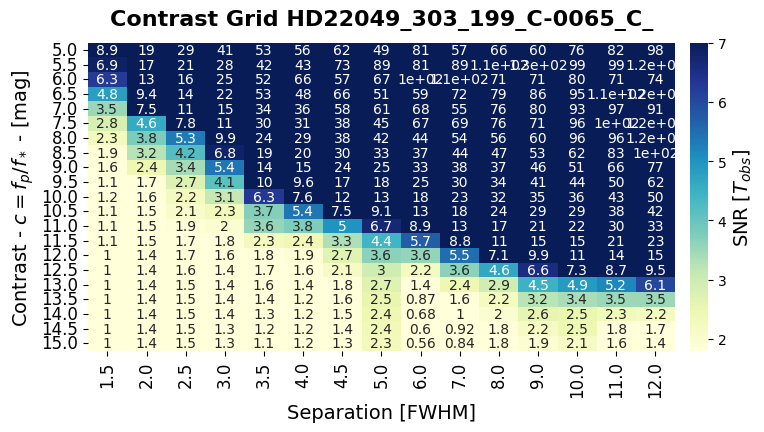

In [72]:
fig = plt.figure(figsize=(8, 4))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=over_all_best)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid " + dataset_name,
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')
plt.savefig("contrast_grid_pca_best_off_" + dataset_name + ".pdf", bbox_inches='tight')

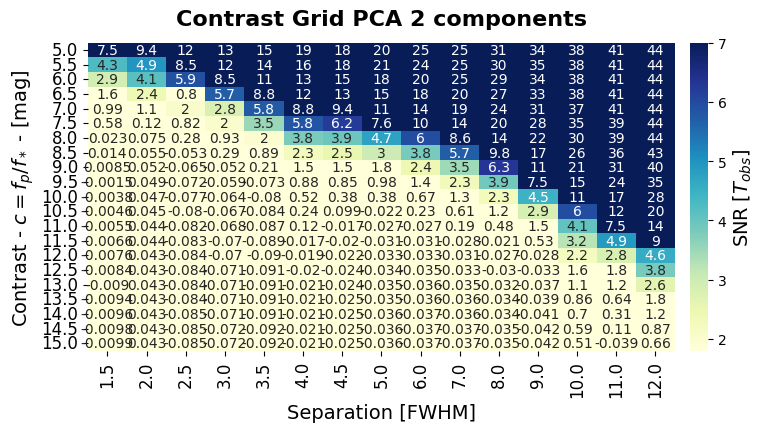

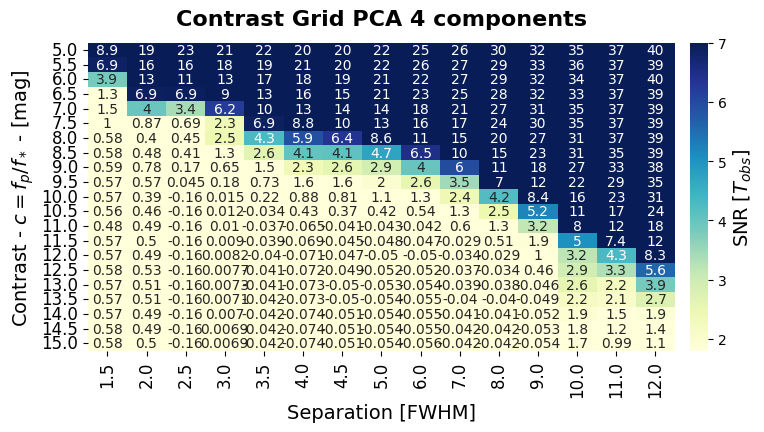

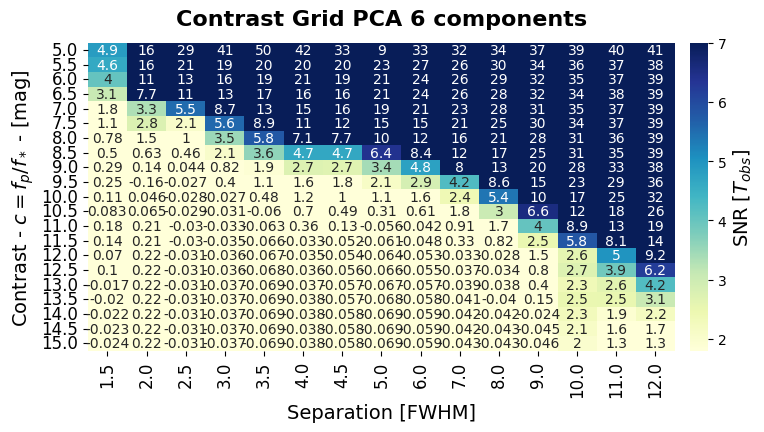

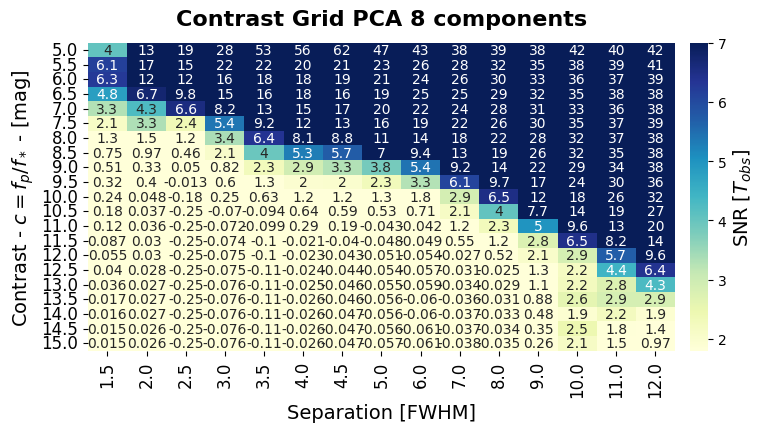

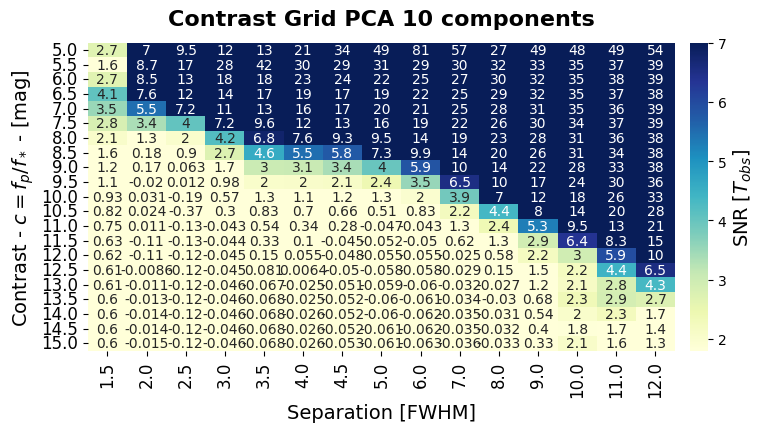

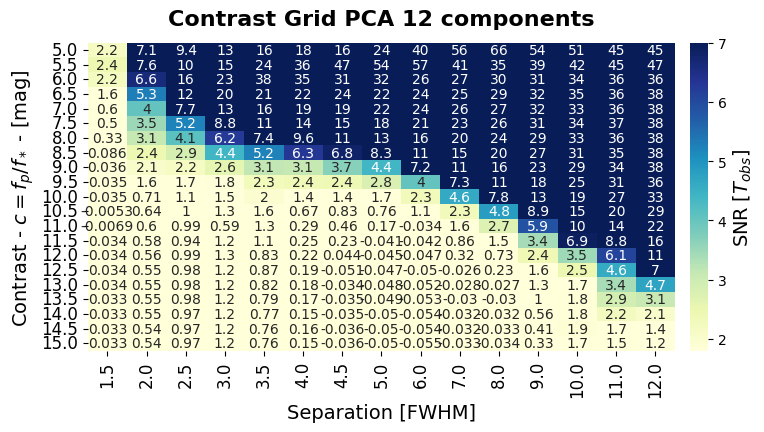

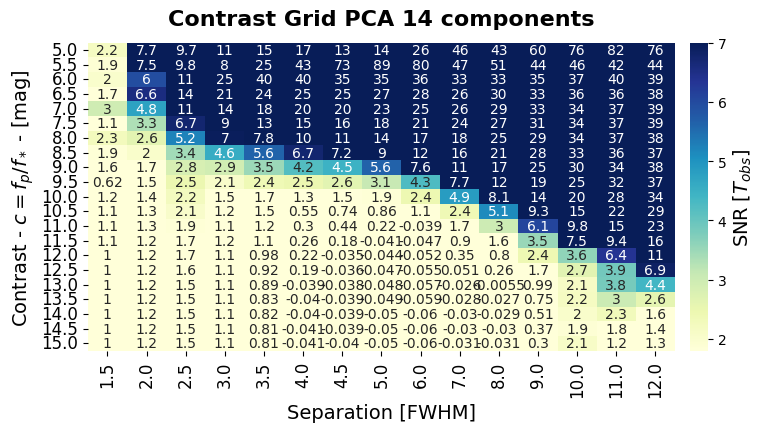

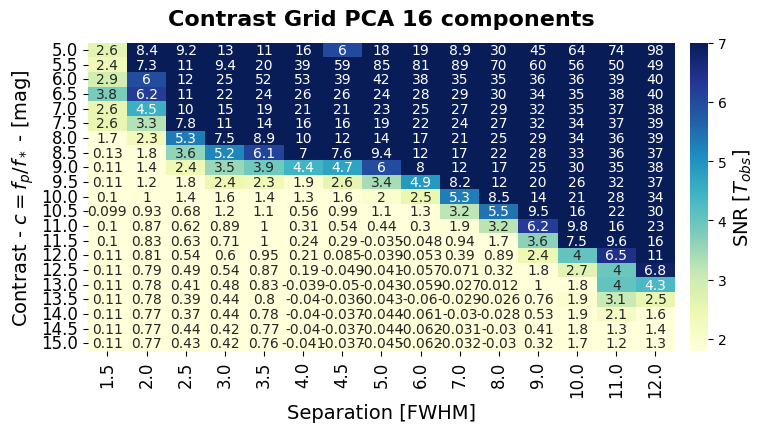

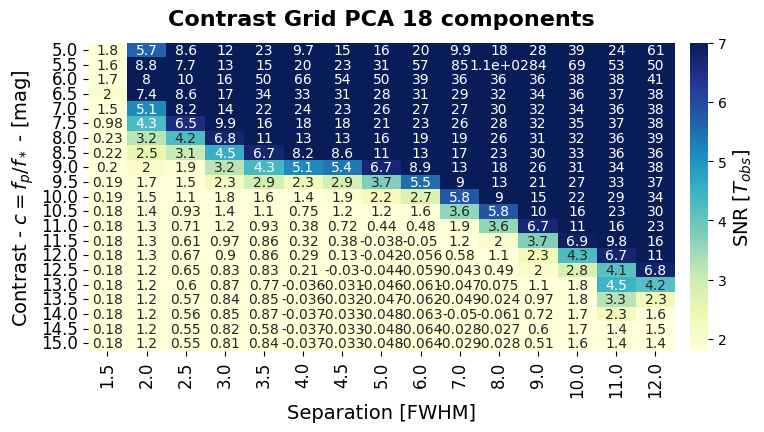

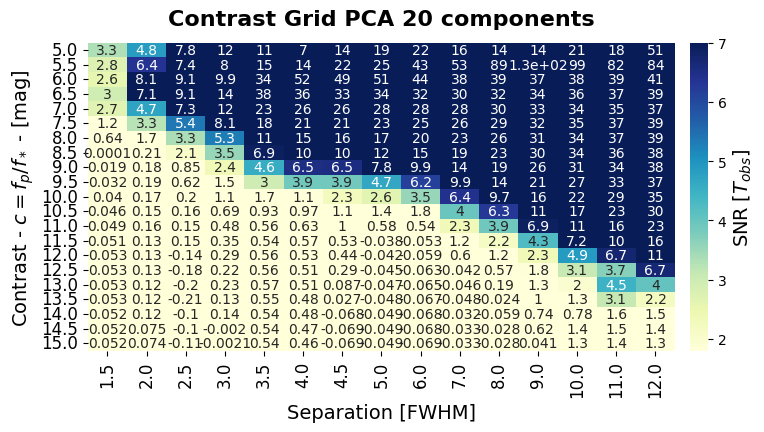

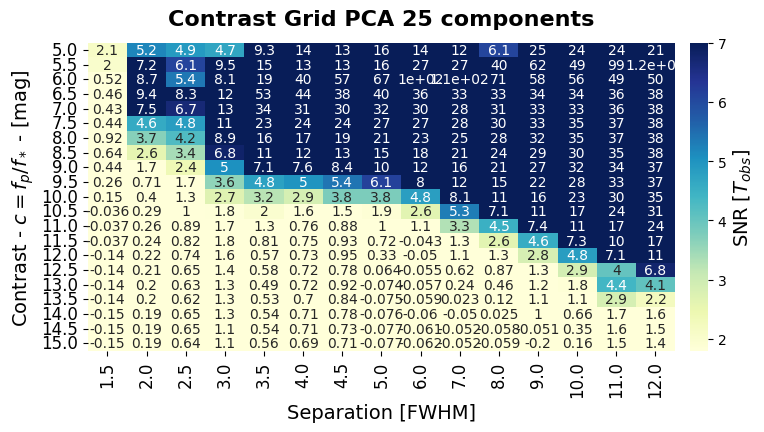

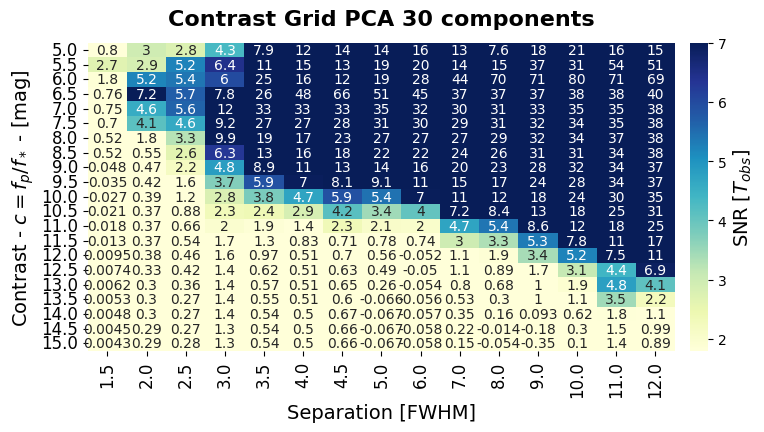

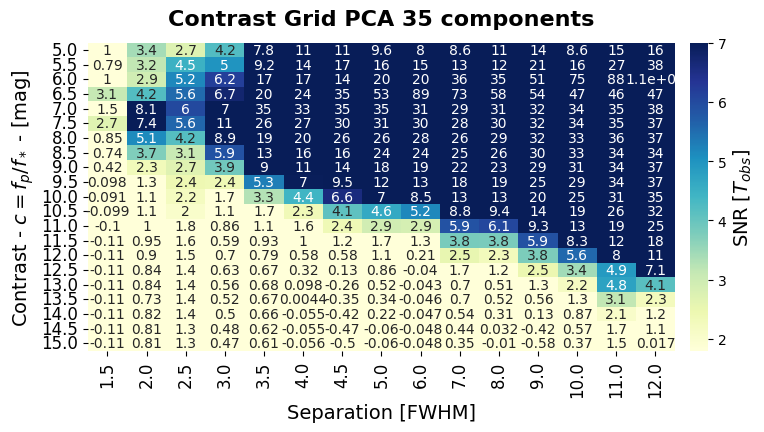

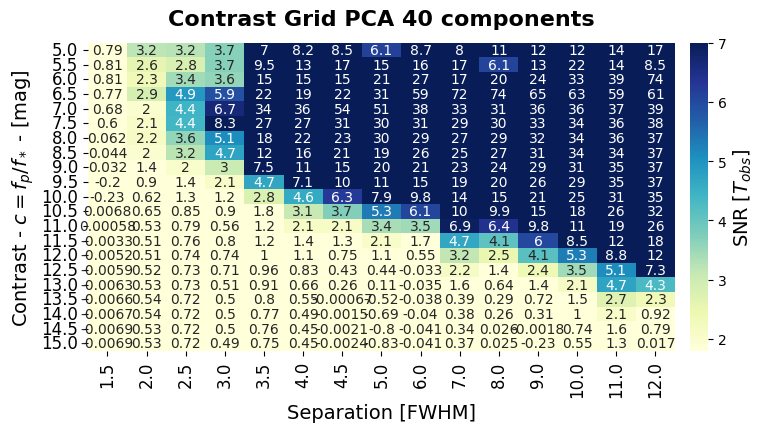

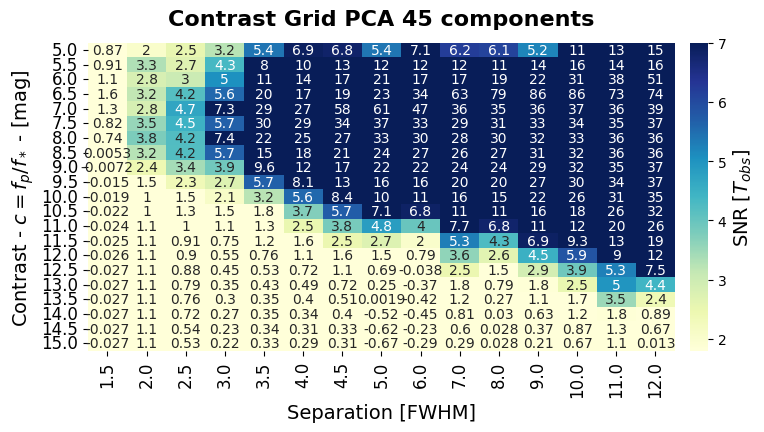

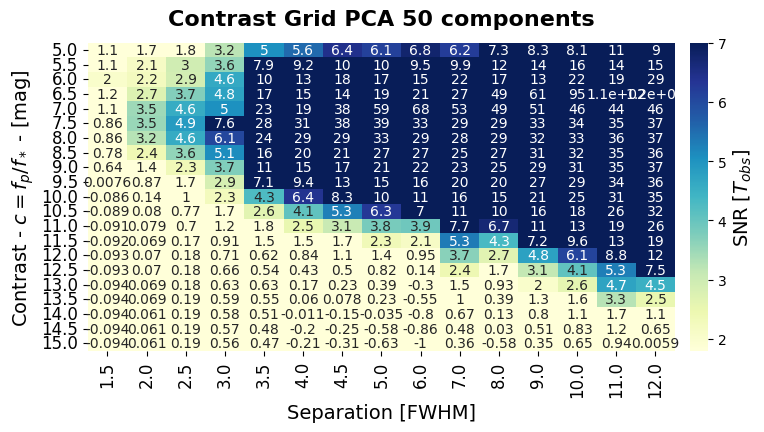

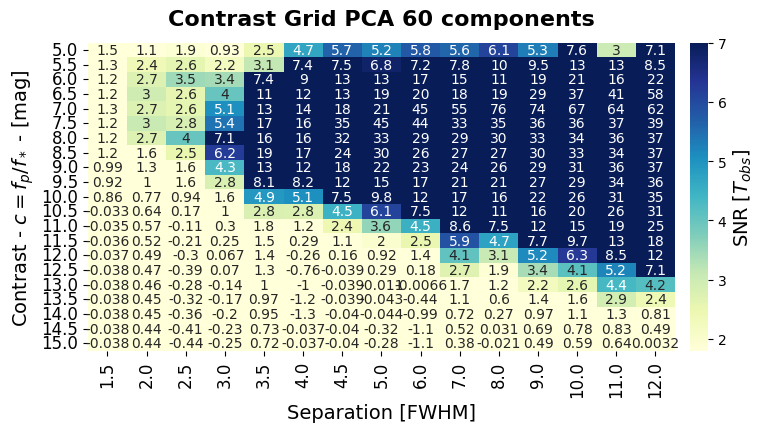

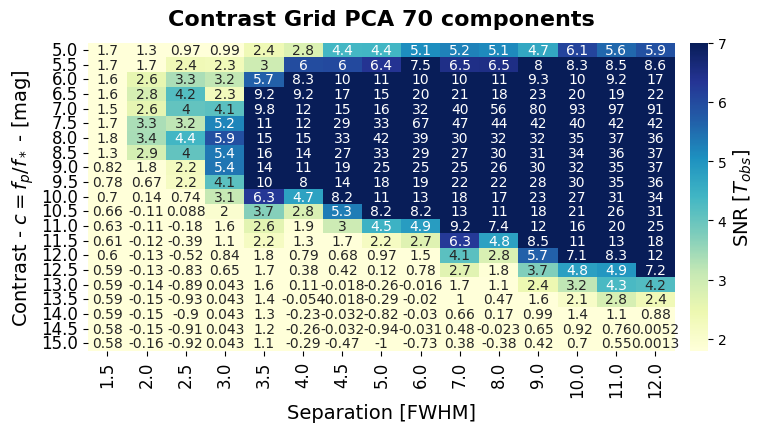

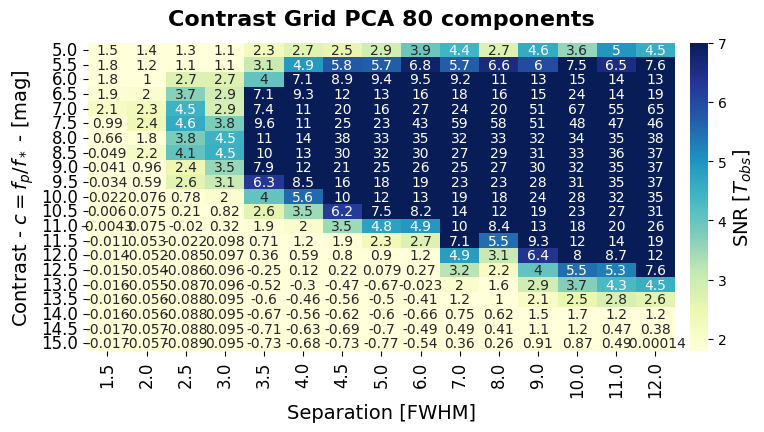

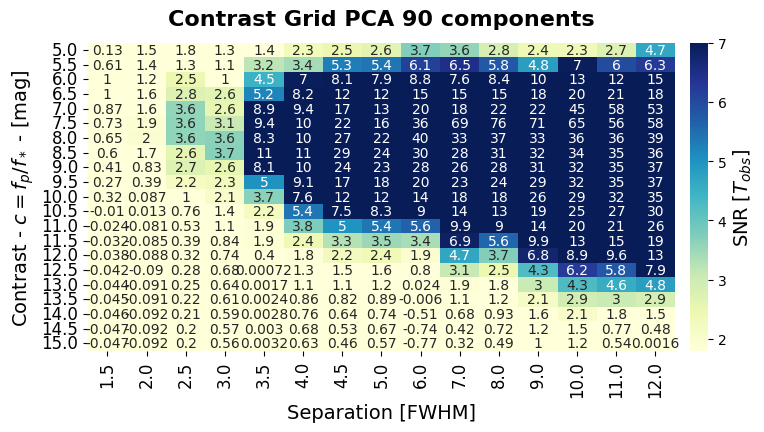

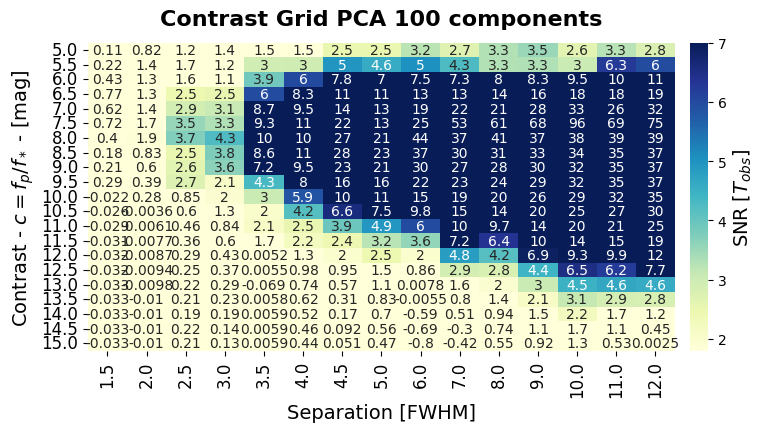

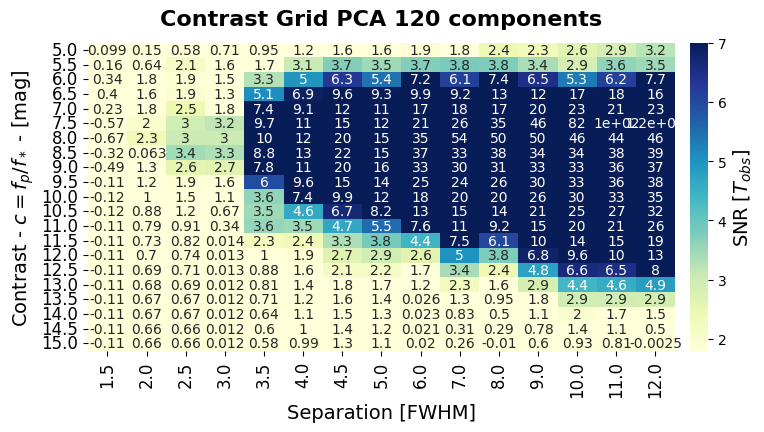

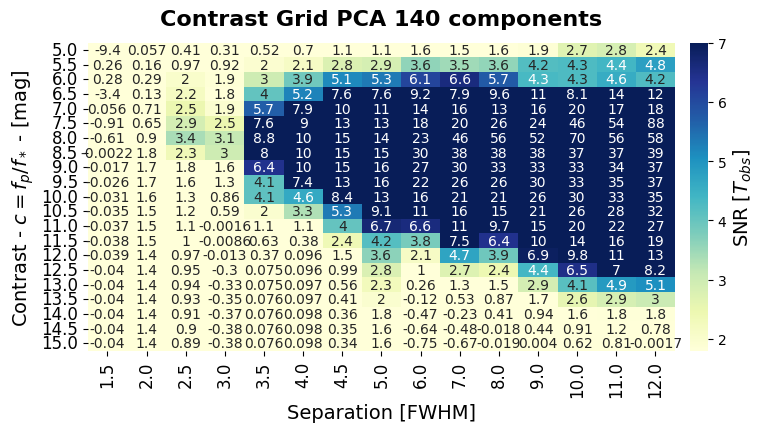

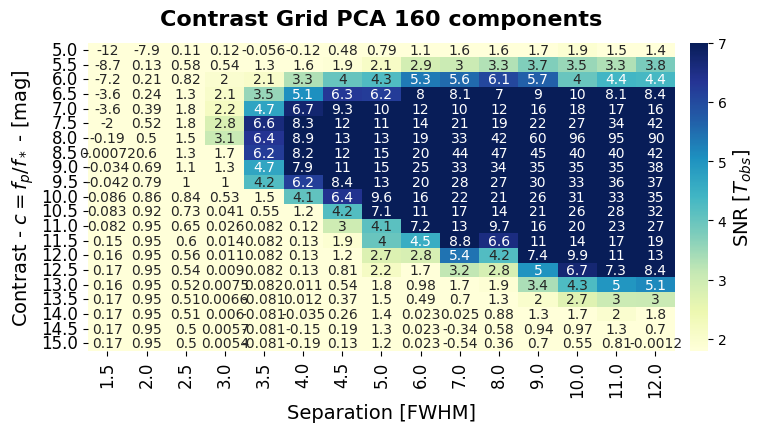

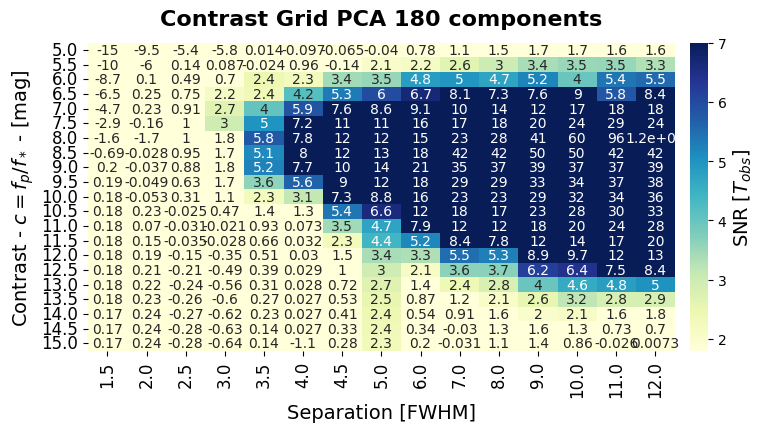

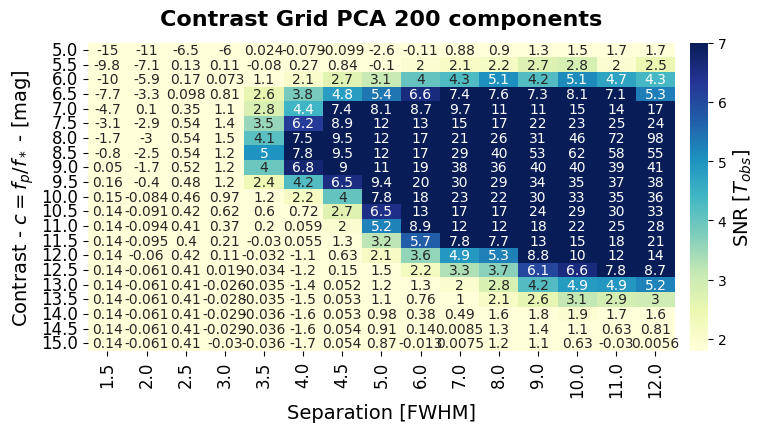

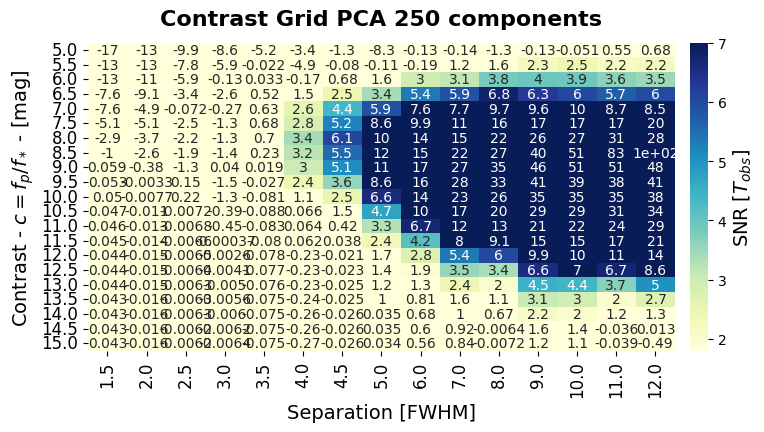

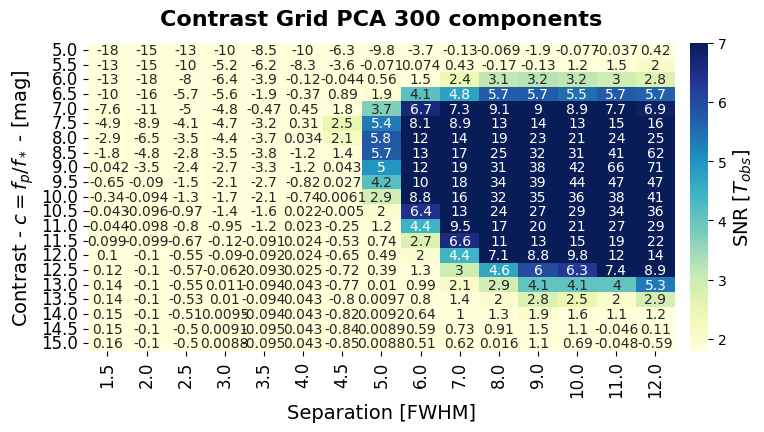

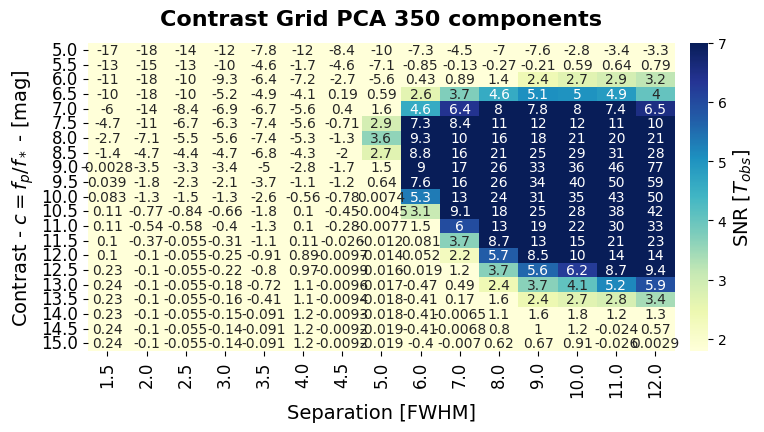

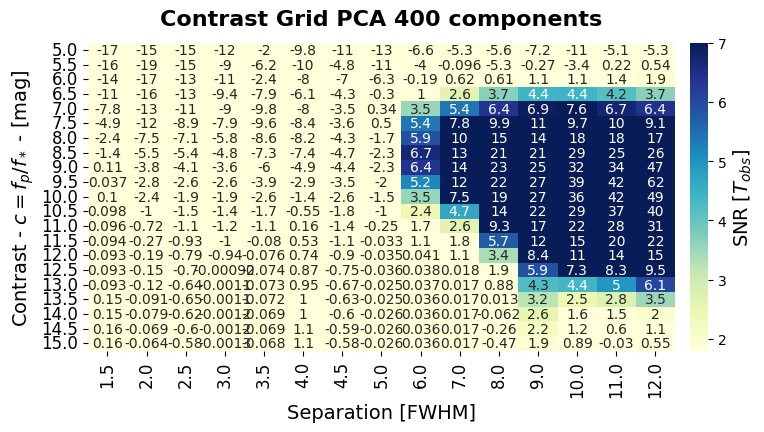

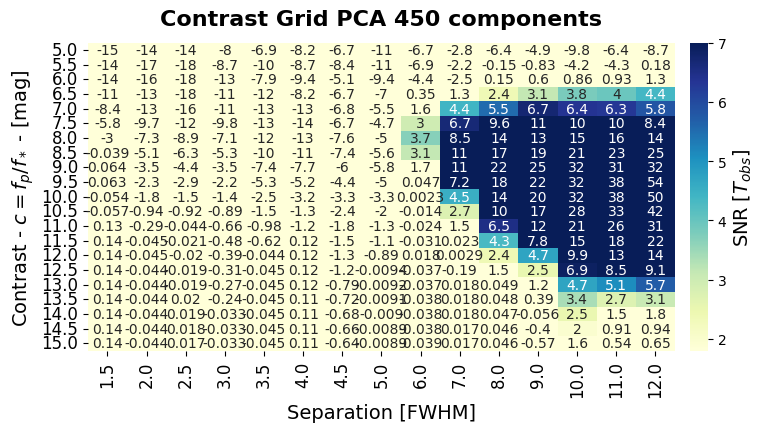

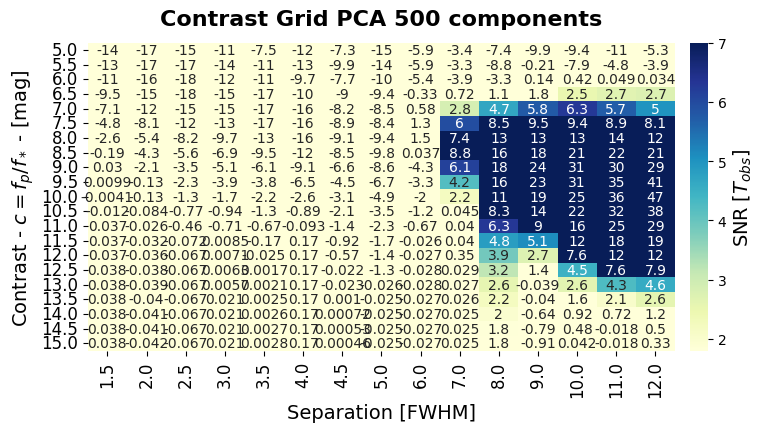

In [73]:
for tmp_model, model_name in [
    ("pca_stacked_05_PCA_002_components", "PCA 2 components"),
    ("pca_stacked_05_PCA_004_components", "PCA 4 components"),
    ("pca_stacked_05_PCA_006_components", "PCA 6 components"),
    ("pca_stacked_05_PCA_008_components", "PCA 8 components"),
    ("pca_stacked_05_PCA_010_components", "PCA 10 components"),
    ("pca_stacked_05_PCA_012_components", "PCA 12 components"),
    ("pca_stacked_05_PCA_014_components", "PCA 14 components"),
    ("pca_stacked_05_PCA_016_components", "PCA 16 components"),
    ("pca_stacked_05_PCA_018_components", "PCA 18 components"),
    ("pca_stacked_05_PCA_020_components", "PCA 20 components"),
    ("pca_stacked_05_PCA_025_components", "PCA 25 components"),
    ("pca_stacked_05_PCA_030_components", "PCA 30 components"),
    ("pca_stacked_05_PCA_035_components", "PCA 35 components"),
    ("pca_stacked_05_PCA_040_components", "PCA 40 components"),
    ("pca_stacked_05_PCA_045_components", "PCA 45 components"),
    ("pca_stacked_05_PCA_050_components", "PCA 50 components"),
    ("pca_stacked_05_PCA_060_components", "PCA 60 components"),
    ("pca_stacked_05_PCA_070_components", "PCA 70 components"),
    ("pca_stacked_05_PCA_080_components", "PCA 80 components"),
    ("pca_stacked_05_PCA_090_components", "PCA 90 components"),
    ("pca_stacked_05_PCA_100_components", "PCA 100 components"),
    ("pca_stacked_05_PCA_120_components", "PCA 120 components"),
    ("pca_stacked_05_PCA_140_components", "PCA 140 components"),
    ("pca_stacked_05_PCA_160_components", "PCA 160 components"),
    ("pca_stacked_05_PCA_180_components", "PCA 180 components"),
    ("pca_stacked_05_PCA_200_components", "PCA 200 components"),
    ("pca_stacked_05_PCA_250_components", "PCA 250 components"),
    ("pca_stacked_05_PCA_300_components", "PCA 300 components"),
    ("pca_stacked_05_PCA_350_components", "PCA 350 components"),
    ("pca_stacked_05_PCA_400_components", "PCA 400 components"),
    ("pca_stacked_05_PCA_450_components", "PCA 450 components"),
    ("pca_stacked_05_PCA_500_components", "PCA 500 components")]:

    s4_contrast_grid = deepcopy(contrast_grids[tmp_model])
    s4_contrast_grid.index = flux_ratio2mag(s4_contrast_grid.index)
    #s4_contrast_grid = s4_contrast_grid.applymap(fpf_2_gaussian_sigma)

    fig = plt.figure(figsize=(8, 4))

    gs0 = fig.add_gridspec(1, 1)
    gs0.update(wspace=0.0, hspace=0.2)
    gs1 = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec = gs0[0],
        wspace=0.05, width_ratios=[1, 0.03])

    # All axis we need
    contrast_ax = fig.add_subplot(gs1[0])
    colorbar_ax = fig.add_subplot(gs1[1])

    # Plot the contrast grid
    plot_contrast_grid(
        contrast_grid_axis=contrast_ax,
        colorbar_axis=colorbar_ax,
        contrast_grid=s4_contrast_grid)

    colorbar_ax.yaxis.label.set_size(14)

    contrast_ax.set_ylabel(
        "Contrast - $c = f_p / f_*$ - [mag]", size=14)
    contrast_ax.set_xlabel(
        r"Separation [FWHM]", size=14)
    contrast_ax.set_title(
        "Contrast Grid " + model_name,
        fontsize=16,
        fontweight="bold",
        y=1.03)

    contrast_ax.tick_params(
        axis='both',
        which='major',
        labelsize=12)

    # Save the figure
    fig.patch.set_facecolor('white')
    plt.show()

/lustre/home/mbonse/2023_s4/50_code/venv_s4/lib/python3.10/site-packages/pandas/core/indexes/base.py:911: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


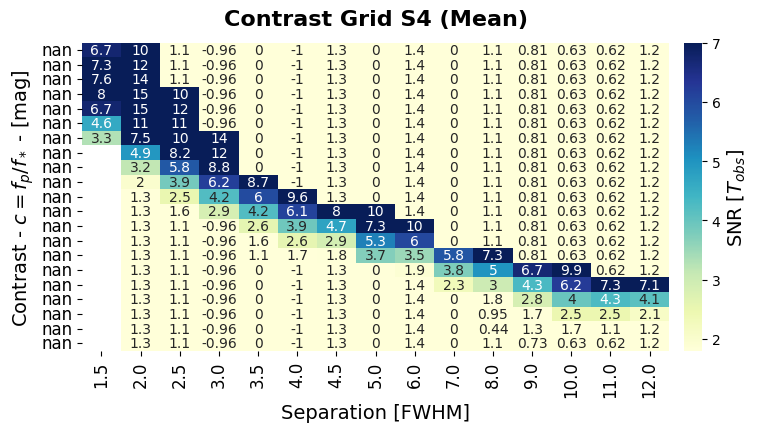

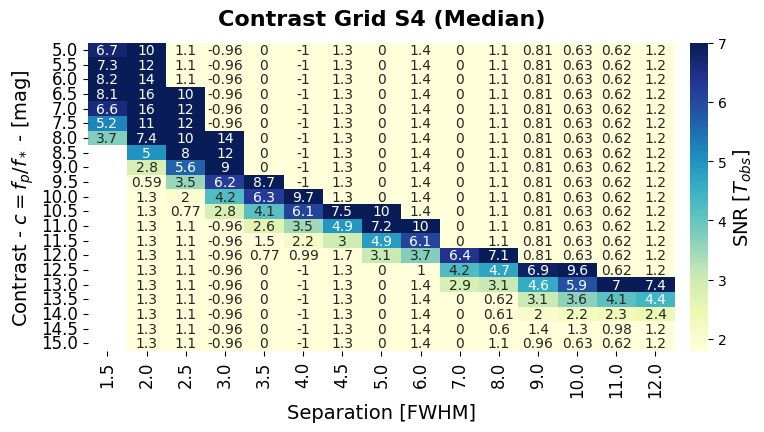

In [74]:
for tmp_model, model_name in [
    ("s4_mean_S4_rotation_loss", "(Mean)"),
    ("s4_median_S4_rotation_loss", "(Median)"),]:

    s4_contrast_grid = deepcopy(contrast_grids[tmp_model])
    s4_contrast_grid.index = flux_ratio2mag(s4_contrast_grid.index)
    #s4_contrast_grid = s4_contrast_grid.applymap(fpf_2_gaussian_sigma)

    fig = plt.figure(figsize=(8, 4))

    gs0 = fig.add_gridspec(1, 1)
    gs0.update(wspace=0.0, hspace=0.2)
    gs1 = gridspec.GridSpecFromSubplotSpec(
        1, 2, subplot_spec = gs0[0],
        wspace=0.05, width_ratios=[1, 0.03])

    # All axis we need
    contrast_ax = fig.add_subplot(gs1[0])
    colorbar_ax = fig.add_subplot(gs1[1])

    # Plot the contrast grid
    plot_contrast_grid(
        contrast_grid_axis=contrast_ax,
        colorbar_axis=colorbar_ax,
        contrast_grid=s4_contrast_grid)

    colorbar_ax.yaxis.label.set_size(14)

    contrast_ax.set_ylabel(
        "Contrast - $c = f_p / f_*$ - [mag]", size=14)
    contrast_ax.set_xlabel(
        r"Separation [FWHM]", size=14)
    contrast_ax.set_title(
        "Contrast Grid S4 " + model_name,
        fontsize=16,
        fontweight="bold",
        y=1.03)

    contrast_ax.tick_params(
        axis='both',
        which='major',
        labelsize=12)

    # Save the figure
    fig.patch.set_facecolor('white')
    plt.savefig("contrast_grid_" + tmp_model + ".pdf", bbox_inches='tight')

# 6. Extract SNR curves from grids

In [75]:
from applefy.utils.contrast_grid import compute_contrast_from_grid

## 6.1 compute all PCA contrast cuves

In [100]:
pca_numbers = np.concatenate([np.arange(0, 20, 2)[1:],
                              np.arange(20, 100, 10),
                              np.arange(100, 200, 20),
                              np.arange(200, 550, 50)])

In [106]:
pca_results = dict()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for tmp_pca_number in pca_numbers:
        tmp_contrast_grid = contrast_grids["pca_stacked_05_PCA_" + str(tmp_pca_number).zfill(3) + "_components"]
        tmp_contrast_grid_fpf = tmp_contrast_grid.applymap(gaussian_sigma_2_fpf)
        tmp_contrast_curve = compute_contrast_from_grid(
            tmp_contrast_grid_fpf.fillna(1e-2), 
            gaussian_sigma_2_fpf(5))
        pca_results[tmp_pca_number] = tmp_contrast_curve.applymap(flux_ratio2mag)

In [107]:
pca_results

{2:              contrast
 separation           
 1.5          5.386410
 2.0          5.494310
 2.5          6.088321
 3.0          6.621442
 3.5          7.168492
 4.0          7.704843
 4.5          7.768533
 5.0          7.955043
 6.0          8.224383
 7.0          8.654984
 8.0          9.269774
 9.0          9.910085
 10.0        10.753746
 11.0        11.478826
 12.0        11.954257,
 4:              contrast
 separation           
 1.5          5.810471
 2.0          6.826542
 2.5          6.773242
 3.0          7.157122
 3.5          7.863943
 4.0          8.246723
 4.5          8.300053
 5.0          8.463373
 6.0          8.798564
 7.0          9.193644
 8.0          9.860615
 9.0         10.551296
 10.0        11.508227
 11.0        11.888537
 12.0        12.675188,
 6:              contrast
 separation           
 1.5               NaN
 2.0          6.808872
 2.5          7.075212
 3.0          7.634763
 3.5          8.180973
 4.0          8.429953
 4.5          8.442573


## 6.2 compute S4 contrast curves

In [111]:
s4_median_contrast_grid = contrast_grids["s4_median_S4_rotation_loss"]
s4_median_contrast_grid_fpf = s4_median_contrast_grid.applymap(gaussian_sigma_2_fpf)
s4_median_contrast_curve = compute_contrast_from_grid(
    s4_median_contrast_grid_fpf.fillna(1e-2), 
    gaussian_sigma_2_fpf(5))
s4_median_contrast_curve = s4_median_contrast_curve.applymap(flux_ratio2mag)

## 6.3 compute the overall best pca curve

In [221]:
overall_best_pca = np.max(np.array([i.fillna(0) for i in pca_results.values()])[:, :, 0], axis=0)

In [134]:
separations_FWHM = s4_median_contrast_curve.index
separations_arcsec = contrast_instance.contrast_results[
    "pca_stacked_05_PCA_002_components"].idx_table.index * pixel_scale

# 7. Plot all results

In [237]:
separations_FWHM = np.round(s4_median_contrast_curve.index, 2)
separations_arcsec = contrast_instance.contrast_results[
    "pca_stacked_05_PCA_002_components"].idx_table.index * pixel_scale

In [157]:
# Find one color for each number of PCA components used.
colors = sns.color_palette("rocket_r", 
    n_colors=len(pca_results))
colors

[(0.97564391, 0.87403763, 0.79725261),
 (0.97071849, 0.82151775, 0.71987163),
 (0.96739773, 0.77451297, 0.65057302),
 (0.96544032, 0.72010124, 0.57640375),
 (0.96443322, 0.67025402, 0.51509334),
 (0.96298491, 0.6126247, 0.45145074),
 (0.96077819, 0.55997184, 0.39941173),
 (0.95681685, 0.49882008, 0.34555431),
 (0.95165009, 0.44224144, 0.30214494),
 (0.94291042, 0.37549479, 0.26369821),
 (0.93078135, 0.31373977, 0.24468803),
 (0.90848638, 0.24568473, 0.24598324),
 (0.87925878, 0.19203259, 0.26268136),
 (0.83850183, 0.14025098, 0.2876878),
 (0.79085854, 0.10184672, 0.313391),
 (0.74297501, 0.08747196, 0.33329799),
 (0.684863, 0.09085633, 0.34914061),
 (0.63139686, 0.10067417, 0.35664819),
 (0.57077365, 0.11135597, 0.35827146),
 (0.51728314, 0.1179558, 0.35453252),
 (0.45809049, 0.12142996, 0.34540024),
 (0.40642019, 0.12151801, 0.33288464),
 (0.34940101, 0.11863987, 0.3138355),
 (0.29977678, 0.11356089, 0.29254823),
 (0.24525608, 0.10497384, 0.26395596),
 (0.19804623, 0.09465217, 0.23478512),
 (0.14633406, 0.07973393, 0.1986151),
 (0.10132312, 0.06286782, 0.16604287),
 (0.05032105, 0.03936808, 0.13020508)]

In [589]:
# Examples for later
example_1 = (1.5, 7.5, 0)
example_2 = (2.5, 9.5, 2)
example_3 = (11., 13., 1)

In [630]:
from matplotlib.legend_handler import HandlerTuple

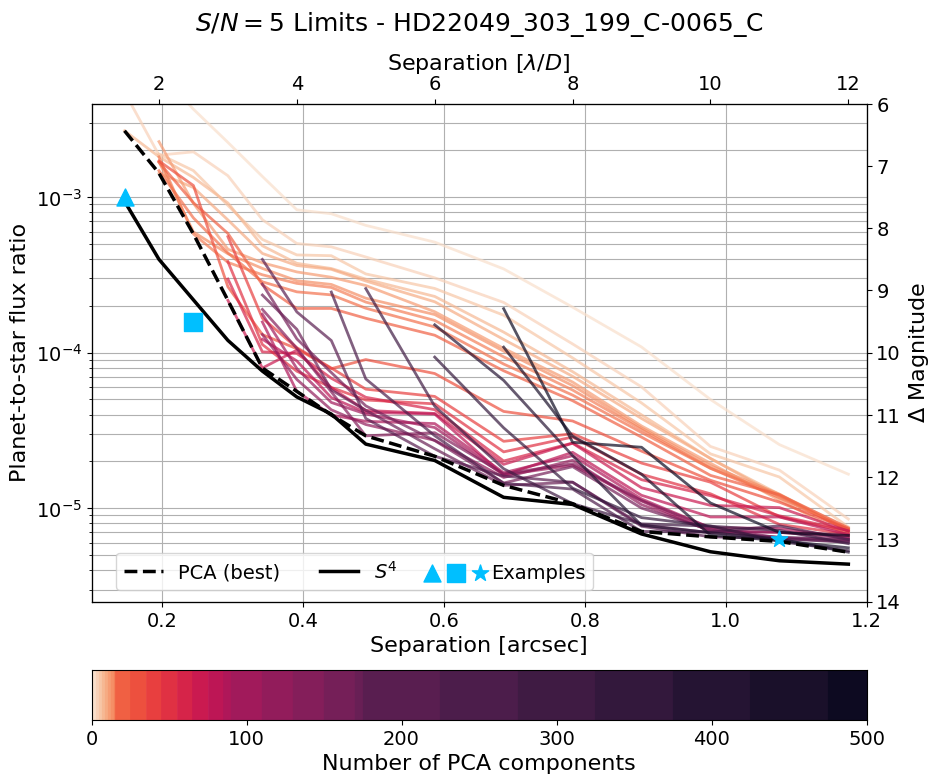

In [679]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(10, 8))
gs0 = fig.add_gridspec(2, 1, height_ratios=[1, 0.1], hspace=0.25)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])

# ------------------- Create the PCA number legend -----------
axis_legend_lines = fig.add_subplot(gs0[1, 0])

for idx, tmp_components in enumerate(pca_results.keys()):
    if tmp_components < 20:
        lw=3
    elif tmp_components < 100:
        lw=12
    elif tmp_components < 200:
        lw=24
    else:
        lw=57
    axis_legend_lines.vlines(
        [tmp_components], 
        ymin=0, ymax=1, color=colors[idx],
        lw=lw)
    
axis_legend_lines.set_xlim(0, 500)
axis_legend_lines.set_ylim(0, 1)
axis_legend_lines.set_yticks([])
axis_legend_lines.tick_params(
    axis='both', which='major', labelsize=14)

axis_legend_lines.set_xlabel("Number of PCA components", size=16)


# ---------------------- Create the PCA plots --------------------
i = 0 # color picker

for pca_number, tmp_contrast_mag in pca_results.items():
    axis_contrast_curvse.plot(
        separations_arcsec,
        mag2flux_ratio(tmp_contrast_mag),
        color = colors[i],
        lw=2,
        alpha=0.7)
    i+=1

axis_contrast_curvse.set_yscale("log")

# ----------- Plot the best PCA contrast -------------------------
pca_plot = axis_contrast_curvse.plot(
    separations_arcsec,
    mag2flux_ratio(overall_best_pca),
    color = "black",
    lw=2.5,
    label="PCA (best)",
    ls="dashed")

# ----------- Plot the raw contrast -------------------------
# TODO: add later

# ----------- Plot the S4 contrast --------------------------
s4_plot = axis_contrast_curvse.plot(
    separations_arcsec,
    mag2flux_ratio(s4_median_contrast_curve),
    color = "black",
    lw=2.5,
    label="$S^4$",
    ls="-")

# ------------- Double axis and limits -----------------------
lim_mag_y = (14, 6)
lim_arcsec_x = (0.1, 1.2)

sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec,
    separations_FWHM,
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    s4_median_contrast_curve,
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    mag2flux_ratio(s4_median_contrast_curve),
    alpha=0.)

axis_contrast_curvse.grid(which='both')
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]),
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ------------- Examples -----------------------
ex1=axis_contrast_curvse.scatter(
    [example_1[0] * fwhm * pixel_scale],
    [mag2flux_ratio(example_1[1])],
    s=150,
    color="deepskyblue",
    marker="^",
    zorder=10)

ex2=axis_contrast_curvse.scatter(
    [example_2[0] * fwhm * pixel_scale],
    [mag2flux_ratio(example_2[1])],
    s=150,
    color="deepskyblue",
    marker="s",
    zorder=10)

ex3=axis_contrast_curvse.scatter(
    [example_3[0] * fwhm * pixel_scale],
    [mag2flux_ratio(example_3[1])],
    s=150,
    color="deepskyblue",
    marker="*",
    zorder=10)

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [$\lambda /D$]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$S/N = 5$ Limits - " + dataset_name[:-1],
    fontsize=18, y=1.13) #fontweight="bold",

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

labels.append("Examples")

# Create a legend with grouped markers and line plot
legend_elements = [
    handles[0],
    handles[1],
    (ex1, ex2, ex3)]

# Add legend
#plt.legend(handles=legend_elements)

leg1 = fig.legend(legend_elements, labels,
                  bbox_to_anchor=(0.14, 0.26),
                  fontsize=14,
                  handler_map={tuple: HandlerTuple(ndivide=None, pad=1.7)},
                  loc='lower left', ncol=3)

_=plt.setp(leg1.get_title(),fontsize=14)
plt.savefig("PCA_vs_S4_" + dataset_name + ".pdf", bbox_inches='tight')

# 9.) Plot some examples

In [199]:
best_number_of_components = pca_numbers[np.argmax(np.array([
    i.fillna(0) for i in pca_results.values()])[:, :, 0], axis=0)]

In [307]:
magnitudes = flux_ratio2mag(s4_median_contrast_grid_fpf.index)

example_1_idx_sep = np.where(separations_FWHM == example_1[0])[0][0]
example_1_idx_mag = np.where(magnitudes == example_1[1])[0][0]
example_1_pcas = best_number_of_components[example_1_idx]


example_2_idx_sep = np.where(separations_FWHM == example_2[0])[0][0]
example_2_idx_mag = np.where(magnitudes == example_2[1])[0][0]
example_2_pcas = best_number_of_components[example_2_idx]

example_3_idx_sep = np.where(separations_FWHM == example_3[0])[0][0]
example_3_idx_mag = np.where(magnitudes == example_3[1])[0][0]
example_3_pcas = best_number_of_components[example_3_idx]

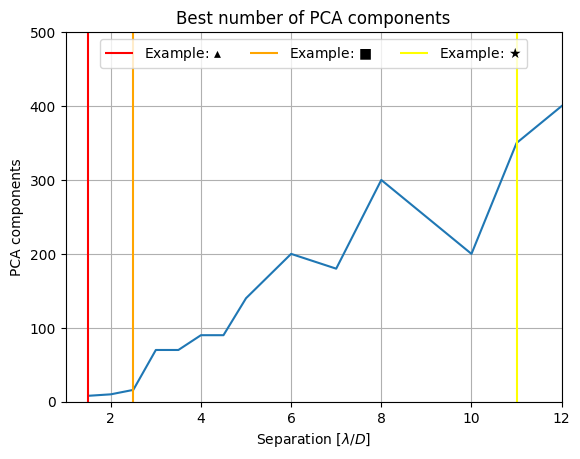

In [665]:
plt.plot(separations_FWHM, best_number_of_components)
plt.vlines([example_1[0],], ymin=0, ymax=500, color="red", label=r"Example: $\blacktriangle$")
plt.vlines([example_2[0],], ymin=0, ymax=500, color="orange", label=r"Example: $\blacksquare$")
plt.vlines([example_3[0],], ymin=0, ymax=500, color="yellow", label=r"Example: $\bigstar$")
plt.grid()
plt.legend(loc='upper center', ncol=3)
plt.xlim(1., 12)
plt.ylim(0, 500)
plt.xlabel("Separation [$\lambda /D$]")
plt.ylabel("PCA components")
plt.title("Best number of PCA components", fontsize=12)
plt.savefig("PCA_vs_S4_" + dataset_name + "_choice_of_components.pdf", bbox_inches='tight')

In [309]:
s4_residuals = contrast_instance.contrast_results["s4_median_S4_rotation_loss"].residuals

In [310]:
s4_residual_1 = s4_residuals[example_1_idx_sep, example_1_idx_mag, example_1[2]]
s4_residual_2 = s4_residuals[example_2_idx_sep, example_2_idx_mag, example_2[2]]
s4_residual_3 = s4_residuals[example_3_idx_sep, example_3_idx_mag, example_3[2]]

In [311]:
tmp_residuals = contrast_instance.contrast_results[
    "pca_stacked_05_PCA_" + str(example_1_pcas).zfill(3) +"_components"].residuals
pca_residual_1 = tmp_residuals[example_1_idx_sep, example_1_idx_mag, example_1[2]]

tmp_residuals = contrast_instance.contrast_results[
    "pca_stacked_05_PCA_" + str(example_2_pcas).zfill(3) +"_components"].residuals
pca_residual_2 = tmp_residuals[example_2_idx_sep, example_2_idx_mag, example_2[2]]

tmp_residuals = contrast_instance.contrast_results[
    "pca_stacked_05_PCA_" + str(example_3_pcas).zfill(3) +"_components"].residuals
pca_residual_3 = tmp_residuals[example_3_idx_sep, example_3_idx_mag, example_3[2]]

In [370]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
color_map = cmocean.cm.ice

In [377]:
def add_colorbar(axis_in, plot_in):
    divider = make_axes_locatable(axis_in)
    cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
    fig.add_axes(cax)
    cbar = fig.colorbar(plot_in, cax=cax, 
                 orientation="horizontal")
    axis_in.set_xticks([]) 
    axis_in.set_yticks([]) 
    cbar.ax.tick_params(labelsize=8)

In [557]:
def annotate_pca(axis_in, num_pca):
    t2 = axis_in.annotate(
    xytext=(5., 9.),
    xy=(0, 0),
    text=str(num_pca) + " components",
    #weight='bold',
    color='w',
    va='top',
    ha='left',
    fontsize=9,
    bbox=dict(facecolor='black', 
          edgecolor='none',
          boxstyle='round',
          alpha=0.5))

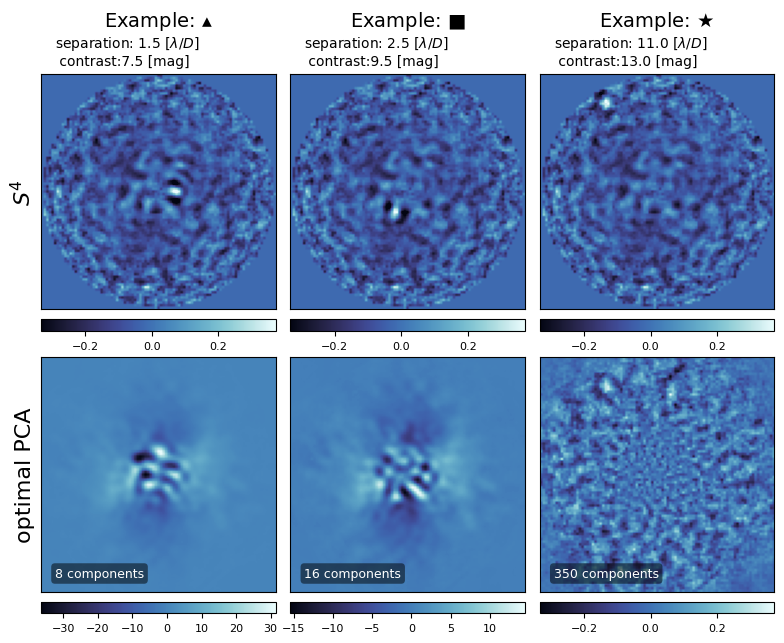

In [657]:
fig = plt.figure(constrained_layout=False, figsize=(9.5, 7))
gs0 = fig.add_gridspec(2, 3, height_ratios=[1, 1],hspace=0.1, wspace=0.05)

axis_pca_1 = fig.add_subplot(gs0[1, 0])
axis_pca_2 = fig.add_subplot(gs0[1, 1])
axis_pca_3 = fig.add_subplot(gs0[1, 2])
axis_s4_1 = fig.add_subplot(gs0[0, 0])
axis_s4_2 = fig.add_subplot(gs0[0, 1])
axis_s4_3 = fig.add_subplot(gs0[0, 2])

# PCA plots -----------------
plot1 = axis_pca_1.imshow(pca_residual_1, cmap=color_map, origin='lower')
add_colorbar(axis_pca_1, plot1)
annotate_pca(axis_pca_1, example_1_pcas)
plot2 = axis_pca_2.imshow(pca_residual_2, cmap=color_map, origin='lower')
add_colorbar(axis_pca_2, plot2)
annotate_pca(axis_pca_2, example_2_pcas)
plot3 = axis_pca_3.imshow(pca_residual_3, cmap=color_map, origin='lower')
add_colorbar(axis_pca_3, plot3)
annotate_pca(axis_pca_3, example_3_pcas)

# S4 plots -----------------
plot4 = axis_s4_1.imshow(s4_residual_1, cmap=color_map, origin='lower',
                         vmin=-0.04, vmax=0.05)
add_colorbar(axis_s4_1, plot3)
plot5 = axis_s4_2.imshow(s4_residual_2, cmap=color_map, origin='lower',
                         vmin=-0.04, vmax=0.05)
add_colorbar(axis_s4_2, plot3)
plot6 = axis_s4_3.imshow(s4_residual_3, cmap=color_map, origin='lower',
                         vmin=-0.04, vmax=0.05)
add_colorbar(axis_s4_3, plot3)

# Titles -----------------
axis_pca_1.set_ylabel("optimal PCA", fontsize=16)
axis_s4_1.set_ylabel("$S^4$", fontsize=16)
axis_s4_1.set_title(r"Example: $\blacktriangle$", fontsize=14, y=1.17)
axis_s4_1.text(5, 94, "separation: " + str(example_1[0]) + " [$\lambda /D$] \n contrast:" + str(example_1[1]) + " [mag]", 
               fontsize=10)

axis_s4_2.set_title(r"Example: $\blacksquare$", fontsize=14, y=1.17)
axis_s4_2.text(5, 94, "separation: " + str(example_2[0]) + " [$\lambda /D$] \n contrast:" + str(example_2[1]) + " [mag]", 
               fontsize=10)
axis_s4_3.set_title(r"Example: $\bigstar$", fontsize=14, y=1.17)
_=axis_s4_3.text(5, 94, "separation: " + str(example_3[0]) + " [$\lambda /D$] \n contrast:" + str(example_3[1]) + " [mag]", 
               fontsize=10)
plt.savefig("PCA_vs_S4_" + dataset_name + "_examples.pdf", bbox_inches='tight')

# 8. Plot relative comparison

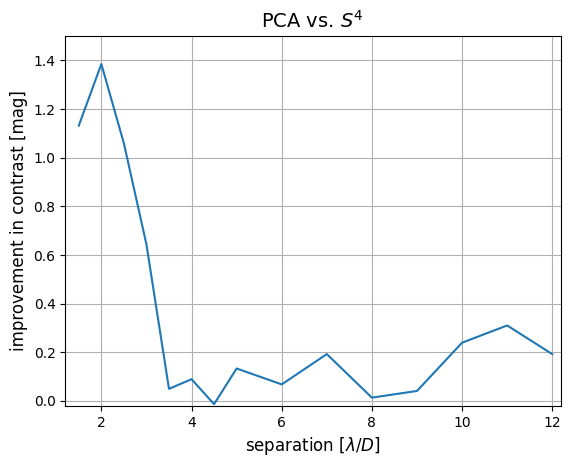

In [678]:
plt.plot(separations_FWHM, (s4_median_contrast_curve.values[:, 0] - overall_best_pca))
plt.grid()
plt.xlim(1.2, 12.2)
plt.ylim(-0.02, 1.5)
plt.xlabel("separation [$\lambda /D$]", fontsize=12)
plt.ylabel("improvement in contrast [mag]", fontsize=12)
plt.title("PCA vs. $S^4$ ", fontsize=14)
plt.savefig("PCA_vs_S4_" + dataset_name + "_relative.pdf", bbox_inches='tight')